## Actionable Insights On New Movies
* Anthony Brocco 
* Full Time NYC-DS-080723
* Phase 2  
* Joe Matta

### In this jupyter notebook we explore movie datasets from:

Box Office https://www.boxofficemojo.com/

IMDB https://www.imdb.com/

Rotten Tomatoes https://www.rottentomatoes.com/

TheMovieDB https://www.themoviedb.org/

The Numbers https://www.the-numbers.com/

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


# What genres should we focus on to maximize roi?

In [2]:
#reading in our cleaned budget dataframe
df_budget = pd.read_csv('../zippedData/movie_budget_cleaned.csv', index_col = 0)

In [3]:
#setting a threshold for 'successful' movies
df_successful = df_budget[df_budget['ROI'] > 1]

In [4]:
#reading in our cleaned basics dataframe
df_basics = pd.read_csv('../zippedData/movie_basics_cleaned.csv',index_col = 0)

In [5]:
# Drop 'movie_id' column from df_basics
df_basics = df_basics.drop('movie_id', axis=1)

# Drop 'id' column from df_successful
df_successful = df_successful.drop('id', axis=1)

# Merge the DataFrames using 'movie' column from df_successful and 'primary_title'
merged_df = pd.merge(df_successful, df_basics, left_on='movie', right_on='primary_title', how='inner')

# Create a new DataFrame by combining 'primary_title' and 'original_title'
merged_df['title'] = merged_df['primary_title'].combine_first(merged_df['original_title'])

# Drop 'primary_title' and 'original_title' columns
merged_df = merged_df.drop(['primary_title', 'original_title'], axis=1)

#Create 'successful_movies' dataframe and clean out unneccesary columns or duplicates
successful_movies_df = merged_df.drop(['title', 'start_year'],axis = 1).drop_duplicates(subset = 'movie')

#filtering for movies with budget greater than $50 Mil to make it more relevant to our budget
relevant_movies_df = successful_movies_df[successful_movies_df['production_budget'] > 50000000]

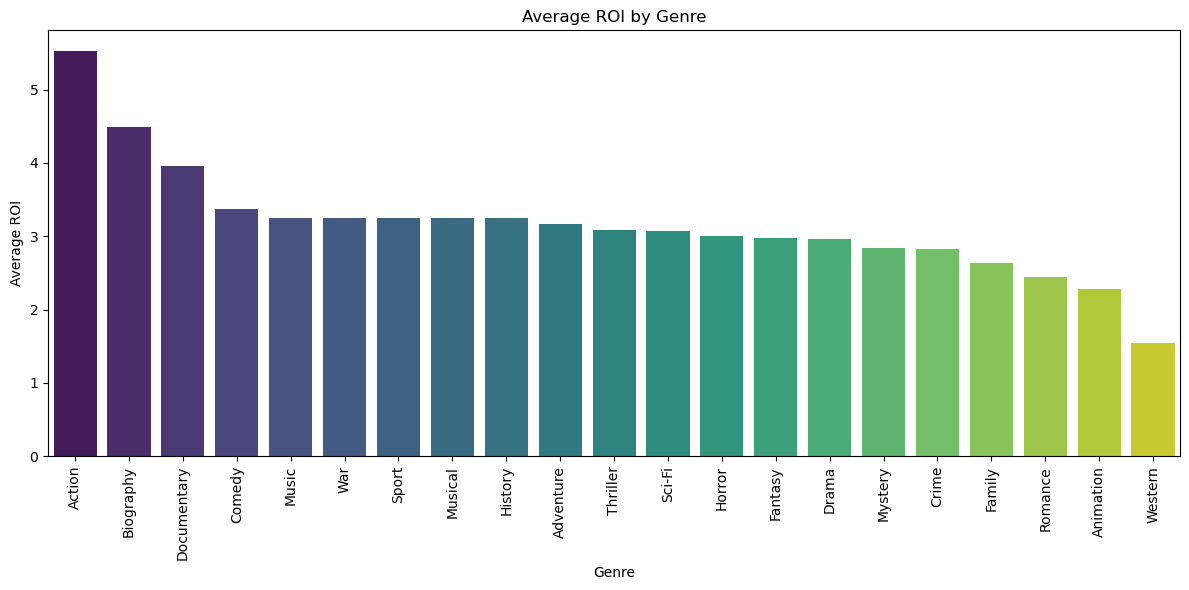

In [6]:
# Here i preprocessed the genres column using the split and stack functions, and then resetting the index
genres_df = relevant_movies_df['genres'].str.split(',', expand=True).stack().reset_index(level=0, drop=True).rename('genre')
merged_df = relevant_movies_df.drop('genres', axis=1).join(genres_df).sort_values(by='ROI', ascending = False)

# Calculate average ROI for each genre
genre_roi_avg = merged_df.groupby('genre')['ROI'].mean().reset_index().sort_values(by='ROI', ascending = False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_roi_avg, x='genre', y='ROI', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.title('Average ROI by Genre')
plt.tight_layout()
plt.show()


# Loading in the sql database

In [9]:
conn = sqlite3.connect('../zippedData/im.db')
people_and_movies_df = pd.read_sql("""
    SELECT p.person_id, primary_name, primary_profession, primary_title, original_title, genres
FROM persons AS p
INNER JOIN known_for AS k ON p.person_id = k.person_id
INNER JOIN movie_basics AS m ON k.movie_id = m.movie_id;

""", conn)
people_and_movies_df.columns

Index(['person_id', 'primary_name', 'primary_profession', 'primary_title',
       'original_title', 'genres'],
      dtype='object')

# What musical artists produce the best soundtracks for based on ROI

In [10]:
# Merge two DataFrames 'merged_df' and 'people_and_movies_df' using an outer join
relevant_people_and_movies = pd.merge(merged_df, people_and_movies_df, how='outer', left_on='movie', right_on='original_title')

# Drop columns we don't need
relevant_people_and_movies = relevant_people_and_movies.drop(['release_date', 'numvotes',
  'runtime_minutes', 'original_title', 'genre'], axis=1)

# Sort the DataFrame by 'ROI' in descending order
relevant_people_and_movies = relevant_people_and_movies.sort_values(by='ROI', ascending=False)

# Drop rows with missing 'primary_profession' values
relevant_people_and_movies = relevant_people_and_movies.dropna(subset=['primary_profession'])

# Filter the DataFrame based on primary profession
chosen_artists = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('soundtrack|composer')]

# Select relevant columns
chosen_artists = chosen_artists[['primary_name', 'primary_profession', 'ROI']]

# Drop duplicate rows, if any
chosen_artists = chosen_artists.drop_duplicates()

# Sort by 'ROI' in descending order (optional)
chosen_artists = chosen_artists.sort_values(by='ROI', ascending=False)

# Chose only 'successful' artists by setting the roi to 10 (a very high roi) and display final result
chosen_artists[chosen_artists['ROI'] > 10]


,primary_name,primary_profession,ROI
31,Richard Armstrong,"music_department,composer,sound_department",15.272461
1,Brian May,"soundtrack,music_department,composer",15.272461
19,Rami Malek,"actor,producer,soundtrack",15.272461
17,Neil Stemp,"music_department,composer,sound_department",15.272461
5,Zubin Mehta,"music_department,soundtrack,actor",15.272461
...,...,...,...
174,Antonio Escobar,"music_department,composer,soundtrack",10.823340
175,Bobby Moynihan,"actor,soundtrack,writer",10.823340
173,William Hughes,"soundtrack,actor",10.823340
193,Mahesh Vashisht,"composer,music_department",10.041042


# What musical artists produce the best soundtracks based on Average Rating

In [12]:
# Sort the DataFrame by 'averagerating' in descending order (change from 'ROI')
relevant_people_and_movies = relevant_people_and_movies.sort_values(by='averagerating', ascending=False)

# Drop rows with missing 'primary_profession' values
relevant_people_and_movies = relevant_people_and_movies.dropna(subset=['primary_profession'])

# Filter the DataFrame based on primary profession
chosen_artists_rating = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('soundtrack|composer')]

# Select relevant columns
chosen_artists_rating = chosen_artists_rating[['primary_name', 'primary_profession', 'averagerating']]

# Drop duplicate rows, if any
chosen_artists_rating = chosen_artists_rating.drop_duplicates()

# Chose only 'successful' artists by setting the averagerating to 7.5 and display the final result
chosen_artists_rating = chosen_artists_rating[chosen_artists_rating['averagerating'] > 7.5]

# Sort by 'averagerating' in descending order (optional)
chosen_artists_rating = chosen_artists_rating.sort_values(by='averagerating', ascending=False)

# Display the final result
chosen_artists_rating


,primary_name,primary_profession,averagerating
2742,Zack Hemsey,"soundtrack,composer,music_department",8.8
2717,Nick Delaplane,"music_department,composer",8.8
2690,Christopher Anderson-Bazzoli,"music_department,composer",8.8
2770,Andrew Kawczynski,"music_department,composer",8.8
2765,Ann Marie Calhoun,"music_department,soundtrack,actress",8.8
...,...,...,...
30735,Steven Price,"music_department,composer,soundtrack",7.6
3676,Cameron Seely,"actress,soundtrack",7.6
2999,Kirk Baily,"actor,miscellaneous,composer",7.6
3634,Adam Gubman,"music_department,composer,soundtrack",7.6


# Here we will filter for top Producers and Directors based on Average Rating

In [14]:
# Merge two DataFrames 'merged_df' and 'people_and_movies_df' using an outer join
relevant_people_and_movies = pd.merge(merged_df, people_and_movies_df, how='outer', left_on='movie', right_on='original_title')

# Drop columns we don't need
relevant_people_and_movies = relevant_people_and_movies.drop(['release_date', 'numvotes',
  'runtime_minutes', 'original_title', 'genre'], axis=1)

# Sort the DataFrame by 'averagerating' in descending order (changed from 'ROI')
relevant_people_and_movies = relevant_people_and_movies.sort_values(by='averagerating', ascending=False)

# Drop rows with missing 'primary_profession' values
relevant_people_and_movies = relevant_people_and_movies.dropna(subset=['primary_profession'])

# Filter the DataFrame based on primary profession (director)
chosen_directors = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('director')]

# Select relevant columns
chosen_directors = chosen_directors[['primary_name', 'primary_profession', 'averagerating']]

# Drop duplicate rows, if any
chosen_directors = chosen_directors.drop_duplicates()

# Sort by 'averagerating' in descending order (optional)
chosen_directors = chosen_directors.sort_values(by='averagerating', ascending=False)

# Display the directors with the highest ratings
chosen_directors


,primary_name,primary_profession,averagerating
2772,Alexandre Ottoveggio,"actor,stunts,director",8.8
2706,James P. Lay,"sound_department,writer,director",8.8
2748,Talulah Riley,"actress,director,writer",8.8
2712,Kevin Westley,"assistant_director,location_management,miscell...",8.8
2713,Chris Patterson,"cinematographer,camera_department,director",8.8
...,...,...,...
832397,Jeffrey Gould,director,NaN
832401,Klaus Erik Okstad,"director,cinematographer,producer",NaN
832402,W Lee Wray,"director,writer,producer",NaN
832404,Thakkali Srinivasan,"director,actor",NaN


# Here we will filter for top Producers and Directors based on ROI

In [15]:
# Filter the DataFrame based on primary profession
chosen_prod_dir = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('producer|director')]

# Select relevant columns
chosen_prod_dir = chosen_prod_dir[['primary_name', 'primary_profession', 'ROI']]

# Drop duplicate rows, if any
chosen_prod_dir = chosen_prod_dir.drop_duplicates()

# Sort by 'ROI' in descending order (optional)
chosen_prod_dir = chosen_prod_dir.sort_values(by='ROI', ascending=False)

# Chose only 'successful' artists by setting the roi to 10 (a very high roi) and display final result
chosen_prod_dir[chosen_prod_dir['ROI'] > 10]


,primary_name,primary_profession,ROI
0,Anthony McCarten,"writer,producer,director",15.272461
4,Tim Plester,"actor,director,producer",15.272461
12,Jim Beach,"producer,actor,miscellaneous",15.272461
11,Dexter Fletcher,"actor,director,writer",15.272461
7,Kieran Hardcastle,"actor,director,writer",15.272461
...,...,...,...
161,Brian Lynch,"writer,actor,director",10.823340
165,Shavo Odadjian,"soundtrack,actor,director",10.823340
164,Kevin Peaty,"animation_department,art_department,director",10.823340
187,Kevin Lincoln,"director,actor,writer",10.041042


# Top actor/actresses based on rating

In [16]:
# Sort the DataFrame by 'averagerating' in descending order
relevant_people_and_movies = relevant_people_and_movies.sort_values(by='averagerating', ascending=False)

# Drop rows with missing 'primary_profession' values
relevant_people_and_movies = relevant_people_and_movies.dropna(subset=['primary_profession'])

# Filter the DataFrame based on primary profession ('actor' or 'actress')
chosen_actors_actresses = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('actor|actress')]

# Select relevant columns
chosen_actors_actresses = chosen_actors_actresses[['primary_name', 'primary_profession', 'averagerating']]

# Drop duplicate rows, if any
chosen_actors_actresses = chosen_actors_actresses.drop_duplicates()

# Chose only 'successful' actors and actresses by setting the averagerating threshold
chosen_actors_actresses = chosen_actors_actresses[chosen_actors_actresses['averagerating'] > 8]

# Sort by 'averagerating' in descending order (optional)
chosen_actors_actresses = chosen_actors_actresses.sort_values(by='averagerating', ascending=False)

# Display the final result
chosen_actors_actresses


,primary_name,primary_profession,averagerating
2772,Alexandre Ottoveggio,"actor,stunts,director",8.8
2751,Thomas Tull,"producer,actor,executive",8.8
2698,Johnny Marr,"soundtrack,composer,actor",8.8
2739,Peres Owino,"actress,writer,producer",8.8
2740,Alex Lombard,"actress,director,writer",8.8
...,...,...,...
4038,Seth Martin,"visual_effects,actor,editor",8.1
4003,Paul Blackwell,"actor,miscellaneous,camera_department",8.1
4020,Nick Holmes,"actor,editor,assistant_director",8.1
4022,Aurelia Abate,"visual_effects,producer,actress",8.1


# top acor/actresses based on ROI

In [17]:
# Sort the DataFrame by 'ROI' in descending order
relevant_people_and_movies = relevant_people_and_movies.sort_values(by='ROI', ascending=False)

# Drop rows with missing 'primary_profession' values
relevant_people_and_movies = relevant_people_and_movies.dropna(subset=['primary_profession'])

# Filter the DataFrame based on primary profession ('actor' or 'actress')
chosen_actors_actresses = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('actor|actress')]

# Select relevant columns
chosen_actors_actresses = chosen_actors_actresses[['primary_name', 'primary_profession', 'ROI']]

# Drop duplicate rows, if any
chosen_actors_actresses = chosen_actors_actresses.drop_duplicates()

# Chose only 'successful' actors and actresses by setting the ROI threshold
chosen_actors_actresses = chosen_actors_actresses[chosen_actors_actresses['ROI'] > 10]

# Sort by 'ROI' in descending order (optional)
chosen_actors_actresses = chosen_actors_actresses.sort_values(by='ROI', ascending=False)

# Display the final result
chosen_actors_actresses


,primary_name,primary_profession,ROI
12,Jim Beach,"producer,actor,miscellaneous",15.272461
7,Kieran Hardcastle,"actor,director,writer",15.272461
28,Ben Hardy,actor,15.272461
14,Lucy Boynton,actress,15.272461
32,Renato Vettore,"actor,music_department,soundtrack",15.272461
...,...,...,...
186,Sarah Brown,actress,10.041042
188,Eliza Jones,actress,10.041042
189,Stuart Moore,actor,10.041042
184,Pete Meads,"actor,camera_department,miscellaneous",10.041042


## Business Questions
What genres should we focus on to maximize ROI?

The code analyzes movie data to determine which movie genres have the highest average Return on Investment (ROI). It helps answer questions related to maximizing financial success in the film industry by identifying the most profitable genres.
We determined that action movies have the highest Return on Investment

We also calculated the average ratings for different movie genres. It provides insights into which genres tend to receive the highest ratings from audiences and critics, which is essential for making decisions about film production.
We found that 

The code identifies musical artists (soundtrack composers) who contribute to movies with the best ratings and ROI. This information can be valuable for studios and filmmakers looking to collaborate with talented composers to enhance their film's soundtrack.

What are the top producers and directors in terms of ROI and ratings?

What are the top actors and actresses in terms of ROI and ratings?

This part of the code focuses on identifying top producers and directors in the film industry based on their ROI. It provides insights into successful individuals who can be considered for future film projects.